## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Бирюков |
|---------|--------|
| Группа  | 7      |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from abc import ABC, abstractmethod
from time import time
import pickle
import gzip

## Фреймворк

Базовые абстрактные классы слоев. Класс *Layer* используется для передаточных функций и функций ошибок. Класс *WeightLayer* - для линейного слоя.

In [2]:
class Layer(ABC):
    def __init__(self):
        self.idx = 0
    
    @abstractmethod
    def forward(self, x):
        pass
    
    @abstractmethod
    def backward(self, dx):
        pass
    
class WeightLayer(Layer):
    @abstractmethod
    def update(self, lr):
        pass

Линейный слой

In [3]:
class Linear(WeightLayer):
    def __init__(self, nin, nout):
        super(Linear).__init__()
        self.W = np.random.normal(0, 1.0 / np.sqrt(2 * nin), (nout, nin))
        self.b = np.zeros((1, nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x = x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self, lr, optim, test=False):
        dW, db = optim.update(self.idx, lr, self.dW, self.db)
        self.W += dW
        self.b += db

Функция Softmax

In [4]:
class Softmax(Layer):
    def forward(self, z):
        self.z = z
        zmax = z.max(axis=1, keepdims=True)
        expz = np.exp(z - zmax)
        Z = expz.sum(axis=1, keepdims=True)
        return expz / Z
    
    def backward(self, dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)

Функции потерь: CrossEntropyLoss, квадратичная ошибка

In [5]:
class CrossEntropyLoss(Layer):
    def forward(self, p, y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    
    def backward(self, loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0 / len(self.y)
        return dlog_softmax / self.p
    
class MeanSquareLoss(Layer):
    def forward(self, p, y):
        self.p = p
        self.y = np.zeros_like(p)
        for i, j in enumerate(y):
            self.y[i, j] = 1
        return np.sum((self.y - self.p) ** 2)
    
    def backward(self, loss):
        return 2 * (self.p - self.y)

Передаточные функции: гиперболический тангенс, ReLU, сигмоида, softplus.

In [6]:
class Tanh(Layer):
    def forward(self, x):
        self.y = np.tanh(x)
        return self.y
    
    def backward(self, dy):
        return (1.0 - self.y ** 2) * dy
    
class ReLU(Layer):
    def forward(self, x):
        self.y = np.maximum(x, np.zeros(x.shape))
        return self.y
    
    def backward(self, dy):
        self.y[self.y > 0] = 1
        return self.y * dy
    
class Sigmoid(Layer):
    def forward(self, x):
        self.y = 1 / (1 + np.exp(-x))
        return self.y
    
    def backward(self, dy):
        return self.y * (1 - self.y) * dy
    
class SoftPlus(Layer):
    def forward(self, x):
        self.x = x
        return np.log(1 + np.exp(x))
    
    def backward(self, dy):
        return 1 / (1 + np.exp(-self.x)) * dy

Оптимизаторы: градиентный спуск, ипульсный градиентный спуск, Adagrad, RMSProp

In [7]:
class GD:
    """Gradient Descent"""
    def __init__(self):
        self.net = None
    
    def init(self, idx):
        pass
    
    def update(self, idx, lr, dW, db):
        return (-lr * dW, -lr * db)
    
    def clear(self):
        pass

class NAG:
    """Nesterov Accelerated Gradient"""
    def __init__(self, beta=0.9):
        self.net = None
        self.beta = beta
        self.vdw = dict()
        self.vdb = dict()
        
    def init(self, idx):
        self.vdw[idx] = np.zeros_like(self.net.layers[idx].W)
        self.vdb[idx] = np.zeros_like(self.net.layers[idx].b)
        
    def update(self, idx, lr, dW, db, test=False):
        if not test:
            self.vdw[idx] = self.beta * self.vdw[idx] + (1 - self.beta) * dW
            self.vdb[idx] = self.beta * self.vdb[idx] + (1 - self.beta) * db
        return (-lr * self.vdw[idx], -lr * self.vdb[idx])
    
    def clear(self):
        for v in self.vdw.values():
            v.fill(0)
        for v in self.vdb.values():
            v.fill(0)

class Adagrad:
    def __init__(self, eps=1e-6):
        self.net = None
        self.eps = eps
        self.Gw = dict()
        self.Gb = dict()
        
    def init(self, idx):
        self.Gw[idx] = np.zeros_like(self.net.layers[idx].W)
        self.Gb[idx] = np.zeros_like(self.net.layers[idx].b)
        
    def update(self, idx, lr, dW, db, test=False):
        if not test:
            self.Gw[idx] += dW ** 2
            self.Gb[idx] += db ** 2
            
        return (-lr / ((self.Gw[idx] + self.eps) ** 0.5) * dW, -lr / ((self.Gb[idx] + self.eps) ** 0.5) * db)
    
    def clear(self):
        for v in self.Gw.values():
            v.fill(0)
        for v in self.Gb.values():
            v.fill(0)

class RMSProp:
    def __init__(self, beta=0.9, eps=1e-6):
        self.net = None
        self.beta = beta
        self.eps = eps
        self.Ew = dict()
        self.Eb = dict()
        
    def init(self, idx):
        self.Ew[idx] = np.zeros_like(self.net.layers[idx].W)
        self.Eb[idx] = np.zeros_like(self.net.layers[idx].b)
        
    def update(self, idx, lr, dW, db, test=False):
        if not test:
            self.Ew[idx] = self.beta * self.Ew[idx] + (1 - self.beta) * dW ** 2
            self.Eb[idx] = self.beta * self.Eb[idx] + (1 - self.beta) * db ** 2
            
        return (-lr / ((self.Ew[idx] + self.eps) ** 0.5) * dW, -lr / ((self.Eb[idx] + self.eps) ** 0.5) * db)
    
    def clear(self):
        for v in self.Ew.values():
            v.fill(0)
        for v in self.Eb.values():
            v.fill(0)

Класс сети. Принимает функцию потерь и оптимизатор.

В обучении оптимизатор используется или напрямую, или с наилучшим шагом, выбранным при помощи тернарного поиска.

In [8]:
class Net:    
    def __init__(self, loss, optimizer, adaptive_lr=False):
        self.layers = []
        self.loss = loss
        self.optimizer = optimizer
        self.optimizer.net = self
        self.adaptive_lr = adaptive_lr
    
    def add(self, *args):
        prev = 0 if len(self.layers) == 0 else self.layers[-1].idx
        for i in range(len(args)):
            self.layers.append(args[i])
            self.layers[-1].idx = prev + i
            if isinstance(self.layers[-1], WeightLayer):
                self.optimizer.init(prev + i)
        
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self, z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def train_epoch(self, train_x, train_labels, batch_size, lr):
        for i in range(0, len(train_x), batch_size):
            xb = train_x[i:i+batch_size]
            yb = train_labels[i:i+batch_size]
            
            p = self.forward(xb)
            l = self.loss.forward(p, yb)
            dp = self.loss.backward(l)
            dx = self.backward(dp)
            
            if self.adaptive_lr:
                l = 1e-6
                r = 500
                while r - l > 1e-6:
                    a = l + (r - l) / 3
                    b = l + 2 * (r - l) / 3
                    
                    self.update(a * lr, True)
                    loss_a = self.get_loss(xb, yb)
                    self.update(-a * lr, True)
                    
                    self.update(b * lr, True)
                    loss_b = self.get_loss(xb, yb)
                    self.update(-b * lr, True)
                    
                    if loss_a < loss_b:
                        r = b
                    else:
                        l = a
                self.update(l * lr)
            else:
                self.update(lr)
                
    def get_confusion_matrix(self, x, y):
        p = np.argmax(self.forward(x), axis=1)
        n = np.unique(y).shape[0]
        cm = np.zeros((n, n))
        for a, b in zip(p, y):
            if a != b:
                cm[a, b] += 1
            cm[b, a] += 1
        return cm
    
    def get_loss(self, x, y):
        p = self.forward(x)
        l = self.loss.forward(p, y)
        return l
    
    def get_acc(self, x, y):
        p = self.forward(x)
        pred = np.argmax(p, axis=1)
        acc = (pred == y).mean()
        return acc
    
    def get_loss_acc(self, x, y):
        p = self.forward(x)
        l = self.loss.forward(p, y)
        pred = np.argmax(p, axis=1)
        acc = (pred == y).mean()
        return l, acc
    
    def update(self, lr, test=False):
        self.optimizer.clear()
        for l in self.layers:
            if isinstance(l, WeightLayer):
                l.update(lr, self.optimizer, test)

Функция обучения нескольких эпох и вывод результатов

In [9]:
def train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size, lr, steps, debug=False):
    print("Initial loss={:.4f}, accuracy={:.4f}".format(*net.get_loss_acc(train_data, train_labels)))
    
    # accuracy = [[net.get_acc(train_data, train_labels)], [net.get_acc(test_data, test_labels)]]
    start = time()
    accuracy = [[], []]
    for i in range(steps):
        net.train_epoch(train_data, train_labels, batch_size, lr)
        train_acc = net.get_acc(train_data, train_labels)
        
        if debug: print(f"Epoch {i+1}: accuracy={train_acc:.4f}")
        accuracy[0].append(train_acc)
        accuracy[1].append(net.get_acc(test_data, test_labels))
    end = time()
    
    print("Final loss={:.4f}, accuracy={:.4f}".format(*net.get_loss_acc(train_data, train_labels)))
    print("Test loss={:.4f}, accuracy={:.4f}".format(*net.get_loss_acc(test_data, test_labels)))
    print("Elapsed time: {:.2f}s".format(end - start))
    
    figure = plt.figure(figsize=(15, 4))
    axes = figure.add_subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    matr = axes.imshow(net.get_confusion_matrix(test_data, test_labels))
    figure.colorbar(matr)
    axes = figure.add_subplot(1, 2, 2)
    plt.xticks(range(1, steps+1))
    plt.plot(range(1, steps+1), accuracy[0], 'k--')
    plt.plot(range(1, steps+1), accuracy[1], 'g-')
    plt.show()

## MNIST

In [10]:
!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!gzip -d mnist.pkl.gz

In [11]:
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

train_data, test_data, train_labels, test_labels = train_test_split(MNIST['Train']['Features'], MNIST['Train']['Labels'], train_size=0.8)
print(train_data.shape, test_data.shape)

(33600, 784) (8400, 784)


### Однослойная сеть

Самый стандартный вариант

Initial loss=81.2199, accuracy=0.0673
Final loss=3.3032, accuracy=0.8548
Test loss=3.5288, accuracy=0.8455
Elapsed time: 5.79s


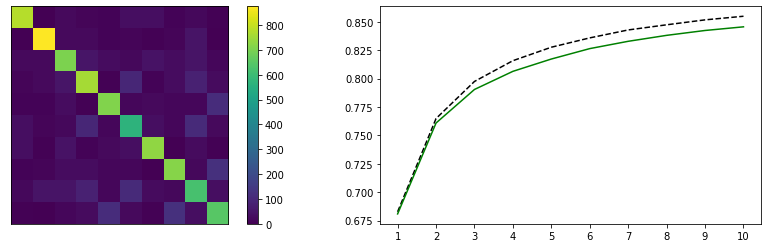

In [45]:
net = Net(loss=CrossEntropyLoss(), optimizer=GD())
net.add(
    Linear(784, 10),
    Softmax()
)

train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.00001, steps=10)

Использование наискорейшего градиентного спуска дает прирост точности, но увеличивает время обучения

Initial loss=70.1529, accuracy=0.1454
Final loss=1.5174, accuracy=0.8781
Test loss=2.0273, accuracy=0.8568
Elapsed time: 142.25s


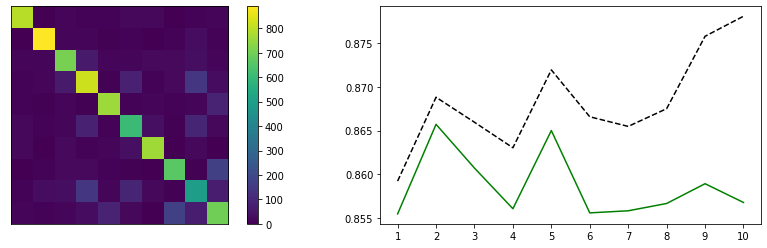

In [13]:
net = Net(loss=CrossEntropyLoss(), optimizer=GD(), adaptive_lr=True)
net.add(
    Linear(784, 10),
    Softmax()
)

train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.000001, steps=10)

Функция квадратичной ошибки допускает более долгое обучения и сильно зависит от начальных весов, приводя к результату от 30%, до 90%

Initial loss=59303.8573, accuracy=0.1021
Final loss=5633.9799, accuracy=0.9148
Test loss=1530.6340, accuracy=0.9076
Elapsed time: 17.71s


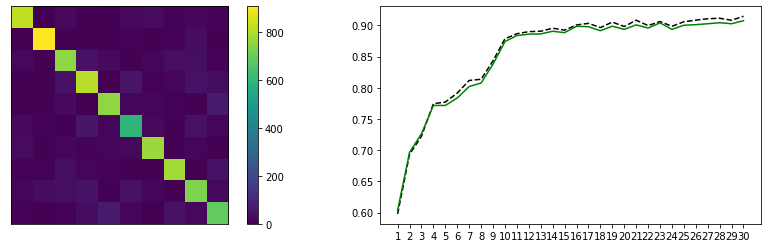

In [47]:
net = Net(loss=MeanSquareLoss(), optimizer=GD())
net.add(
    Linear(784, 10),
    Softmax()
)

train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.00001, steps=30)

Использование разных оптимизаторов. При фиксированном количестве эпох лучший результат получается при использовании RMSProp, затем градиентного спуска и Adagrad, наконец импульсного градиентного спуска

У первых двух наблюдается бо́льшая разница между точностью на тренировочных и тестовых данных

Initial loss=102.9793, accuracy=0.1024
Final loss=3.9336, accuracy=0.8391
Test loss=4.0382, accuracy=0.8351
Elapsed time: 5.98s


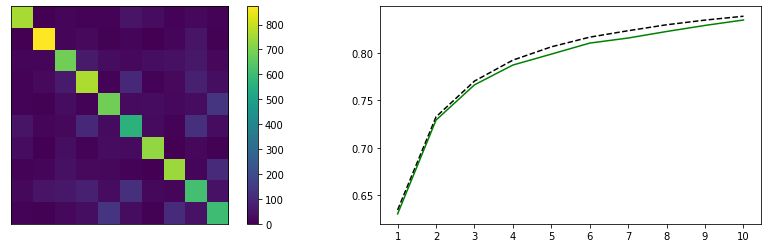

Initial loss=93.6645, accuracy=0.0785
Final loss=2.6612, accuracy=0.8869
Test loss=2.9779, accuracy=0.8774
Elapsed time: 6.04s


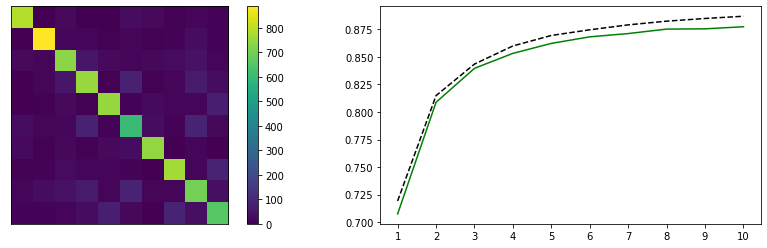

Initial loss=81.9427, accuracy=0.0947
Final loss=2.1212, accuracy=0.8987
Test loss=2.7278, accuracy=0.8830
Elapsed time: 6.12s


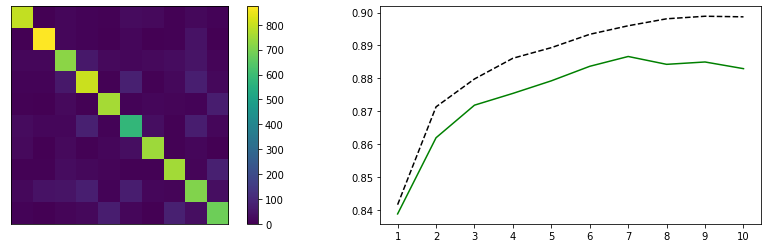

Initial loss=96.7170, accuracy=0.1021
Final loss=1.3512, accuracy=0.9015
Test loss=1.9370, accuracy=0.8744
Elapsed time: 5.80s


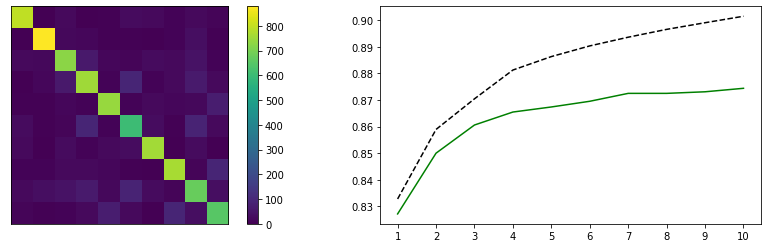

In [15]:
net = Net(loss=CrossEntropyLoss(), optimizer=NAG())
net.add(
    Linear(784, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.00007, steps=10)

net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.00007, steps=10)

net = Net(loss=CrossEntropyLoss(), optimizer=RMSProp())
net.add(
    Linear(784, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.00007, steps=10)

net = Net(loss=CrossEntropyLoss(), optimizer=GD())
net.add(
    Linear(784, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.00007, steps=10)

Лучший результат - CrossEntropyLoss + Adagrad (или RMSProp) - 88%

Initial loss=81.1267, accuracy=0.1150
Final loss=2.4834, accuracy=0.8891
Test loss=2.8453, accuracy=0.8823
Elapsed time: 13.00s


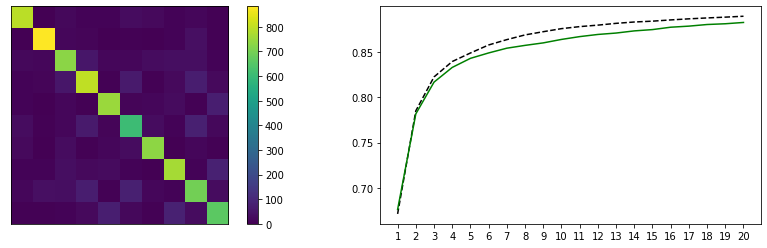

In [44]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.00005, steps=20)

### Многослойная сеть

При увеличении размера второго слоя увеличивается точность, но вместе с ней и переобучение. Остановимся на 200 нейронах

Initial loss=2.5718, accuracy=0.1072
Final loss=1.0186, accuracy=0.7678
Test loss=1.0490, accuracy=0.7490
Elapsed time: 23.88s


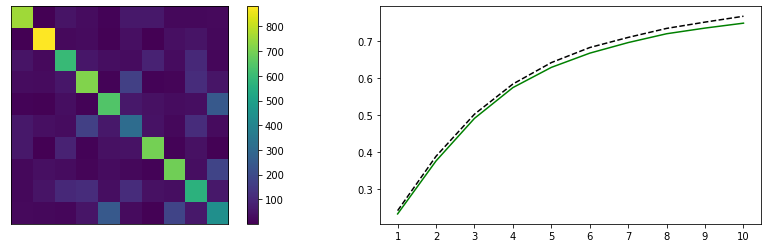

In [16]:
net = Net(loss=CrossEntropyLoss(), optimizer=GD())
net.add(
    Linear(784, 200),
    Tanh(),
    Linear(200, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=10)

Сигмоида требует большего обучения, Softplus и ReLU показывают сходные между собой результаты лучше тангенса

Initial loss=2.3722, accuracy=0.0916
Final loss=1.5863, accuracy=0.6877
Test loss=1.5968, accuracy=0.6864
Elapsed time: 26.58s


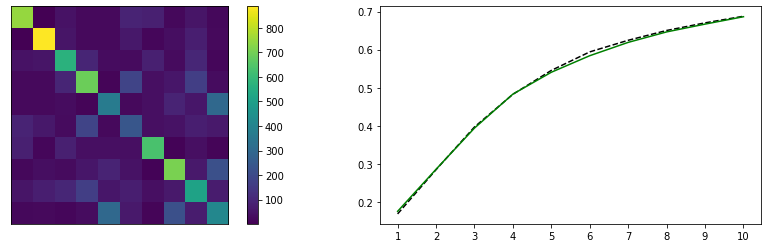

Initial loss=44.5760, accuracy=0.0902
Final loss=0.3731, accuracy=0.9366
Test loss=0.6448, accuracy=0.9089
Elapsed time: 28.97s


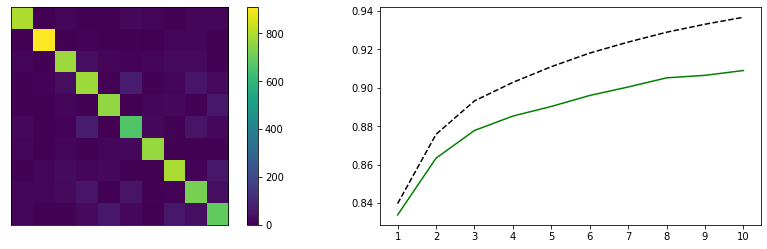

Initial loss=39.7266, accuracy=0.1391
Final loss=0.3622, accuracy=0.9380
Test loss=0.6451, accuracy=0.9120
Elapsed time: 24.21s


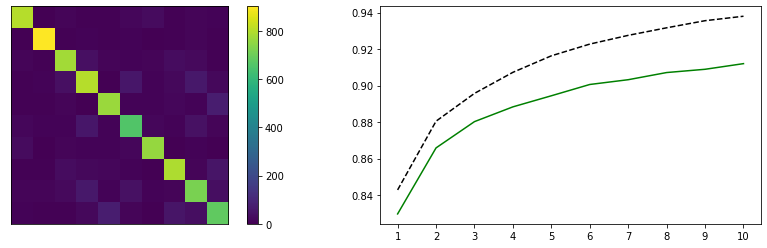

In [17]:
net = Net(loss=CrossEntropyLoss(), optimizer=GD())
net.add(
    Linear(784, 200),
    Sigmoid(),
    Linear(200, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=10)

net = Net(loss=CrossEntropyLoss(), optimizer=GD())
net.add(
    Linear(784, 200),
    SoftPlus(),
    Linear(200, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=10)

net = Net(loss=CrossEntropyLoss(), optimizer=GD())
net.add(
    Linear(784, 200),
    ReLU(),
    Linear(200, 10),
    Softmax()
)
train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=10)

Наилучшие варианты:

RMSProp + ReLU - 96%, при этом точность на обучающих данных приближается к 100%

Initial loss=53.6282, accuracy=0.0775
Final loss=0.0364, accuracy=0.9929
Test loss=0.5434, accuracy=0.9604
Elapsed time: 80.11s


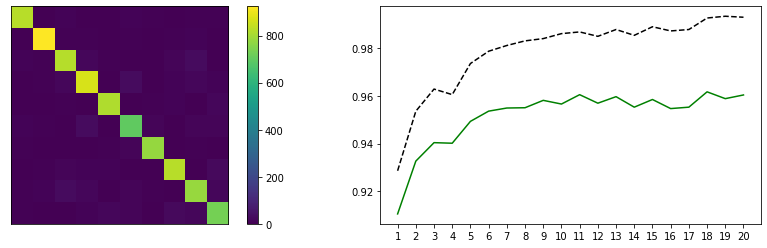

In [18]:
net = Net(loss=CrossEntropyLoss(), optimizer=RMSProp())
net.add(
    Linear(784, 200),
    ReLU(),
    Linear(200, 10),
    Softmax()
)

train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=20)

Adagrad + ReLU - 95%

Initial loss=49.0022, accuracy=0.0646
Final loss=0.0629, accuracy=0.9901
Test loss=0.4987, accuracy=0.9526
Elapsed time: 67.85s


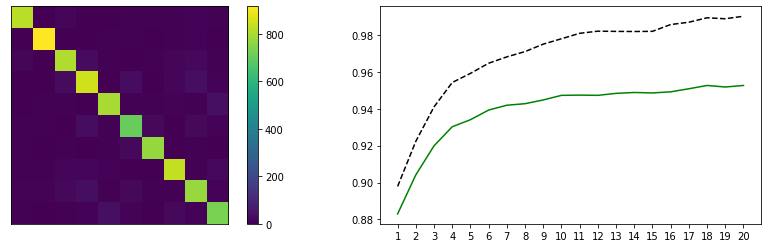

In [19]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 200),
    ReLU(),
    Linear(200, 10),
    Softmax()
)

train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=20)

Добавление третьего слоя немного увеличивает точность, оставляя те же проблемы

Initial loss=22.3153, accuracy=0.1076
Final loss=0.0065, accuracy=0.9982
Test loss=0.3246, accuracy=0.9692
Elapsed time: 86.41s


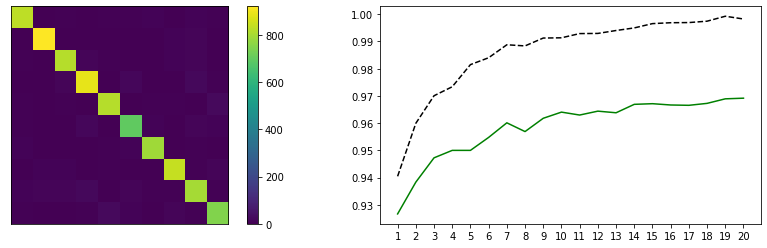

In [20]:
net = Net(loss=CrossEntropyLoss(), optimizer=RMSProp())
net.add(
    Linear(784, 200),
    ReLU(),
    Linear(200, 100),
    ReLU(),
    Linear(100, 10),
    Softmax()
)

train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=20)

Initial loss=25.8568, accuracy=0.1046
Final loss=0.0177, accuracy=0.9955
Test loss=0.2933, accuracy=0.9586
Elapsed time: 77.08s


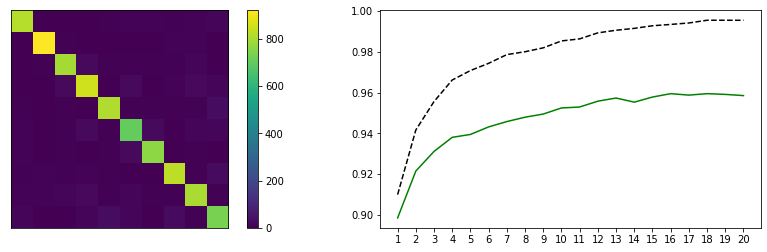

In [21]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 200),
    ReLU(),
    Linear(200, 100),
    ReLU(),
    Linear(100, 10),
    Softmax()
)

train_and_plot(net, train_data, train_labels, test_data, test_labels, batch_size=100, lr=0.0001, steps=20)

## Fashion-MNIST

In [22]:
!curl -o test-images.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz
!curl -o test-labels.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-labels-idx1-ubyte.gz
!curl -o train-images.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-images-idx3-ubyte.gz
!curl -o train-labels.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-labels-idx1-ubyte.gz

In [23]:
with gzip.open("test-labels.gz", "rb") as gz:
    fm_test_labels = np.frombuffer(gz.read(), dtype=np.uint8, offset=8)
with gzip.open("test-images.gz", "rb") as gz:
    fm_test_data = np.frombuffer(gz.read(), dtype=np.uint8, offset=16).reshape(len(fm_test_labels), 784)
    
with gzip.open("train-labels.gz", "rb") as gz:
    fm_train_labels = np.frombuffer(gz.read(), dtype=np.uint8, offset=8)
with gzip.open("train-images.gz", "rb") as gz:
    fm_train_data = np.frombuffer(gz.read(), dtype=np.uint8, offset=16).reshape(len(fm_train_labels), 784)
    
print(fm_train_data.shape, fm_test_data.shape)

(60000, 784) (10000, 784)


### Однослойные сети

Наискорейший градиентный спуск - точность 78% за 4-5 минут обучения

Initial loss=121.7972, accuracy=0.1274
Final loss=2.8283, accuracy=0.8034
Test loss=3.3955, accuracy=0.7844
Elapsed time: 253.15s


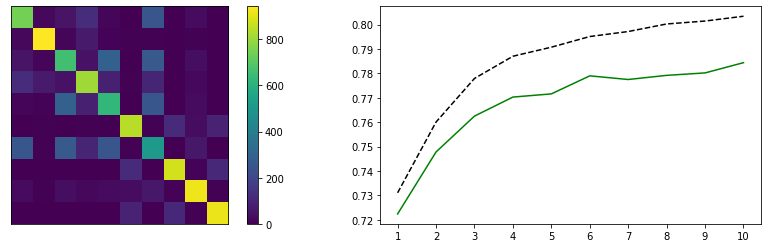

In [24]:
net = Net(loss=CrossEntropyLoss(), optimizer=GD(), adaptive_lr=True)
net.add(
    Linear(784, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.0000001, steps=10)

Adagrad - та же точность даже при том же числе эпох, с потенциальной возможностью увеличения их числа

Initial loss=130.1588, accuracy=0.0590
Final loss=4.0745, accuracy=0.7958
Test loss=4.7205, accuracy=0.7838
Elapsed time: 10.32s


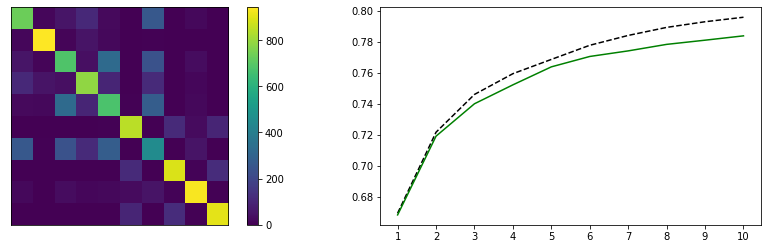

In [52]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.00004, steps=10)

### Двуслойные сети

Эмпирическим путем установлено, что оптимальным числом нейронов во втором слое является 90

Лучший результат - Adagrad + ReLU - 84%

Initial loss=78.1822, accuracy=0.1098
Final loss=0.6983, accuracy=0.8737
Test loss=1.0155, accuracy=0.8454
Elapsed time: 47.35s


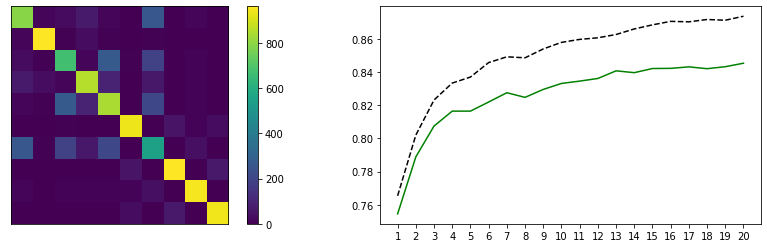

In [29]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 90),
    ReLU(),
    Linear(90, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.0001, steps=20)

RMSProp + ReLU - немного хуже, 83%

Initial loss=45.6044, accuracy=0.0973
Final loss=0.6921, accuracy=0.8598
Test loss=0.9702, accuracy=0.8318
Elapsed time: 49.88s


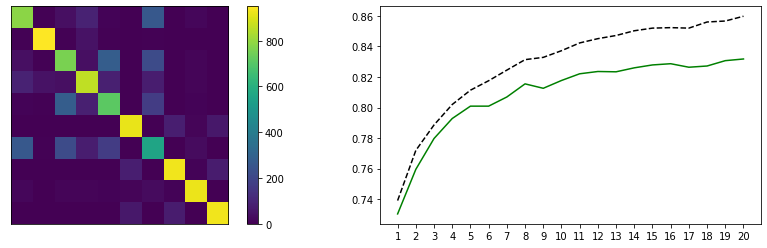

In [ ]:
net = Net(loss=CrossEntropyLoss(), optimizer=RMSProp())
net.add(
    Linear(784, 90),
    ReLU(),
    Linear(90, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.00001, steps=20)

### Трехслойные сети

Оптимальная конфигурация: 784 - 90 - 80 - 10

Adagrad или RMSProp - 85%

Initial loss=29.3050, accuracy=0.0235
Final loss=0.5089, accuracy=0.8810
Test loss=0.8031, accuracy=0.8515
Elapsed time: 67.78s


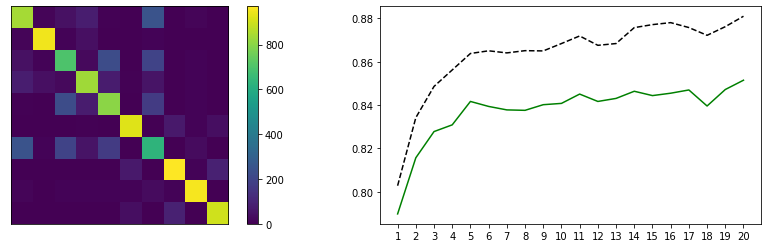

In [33]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 90),
    ReLU(),
    Linear(90, 80),
    ReLU(),
    Linear(80, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.0001, steps=20)

Initial loss=19.6581, accuracy=0.0718
Final loss=0.4574, accuracy=0.8837
Test loss=0.6942, accuracy=0.8555
Elapsed time: 60.26s


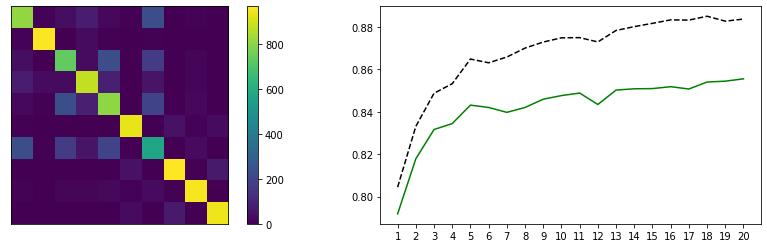

In [61]:
net = Net(loss=CrossEntropyLoss(), optimizer=RMSProp())
net.add(
    Linear(784, 90),
    ReLU(),
    Linear(90, 80),
    ReLU(),
    Linear(80, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.00004, steps=20)

Дальнейшее увеличение числа слоев ведет к незначительному увеличению точности. При этом конфигурации, в которых каждый следующий слой на 10 меньше предыдущего по прежнему остаются оптимальными. RMSProp начинает уступать Adagrad

Initial loss=10.6480, accuracy=0.0868
Final loss=0.3841, accuracy=0.8852
Test loss=0.5630, accuracy=0.8573
Elapsed time: 69.03s


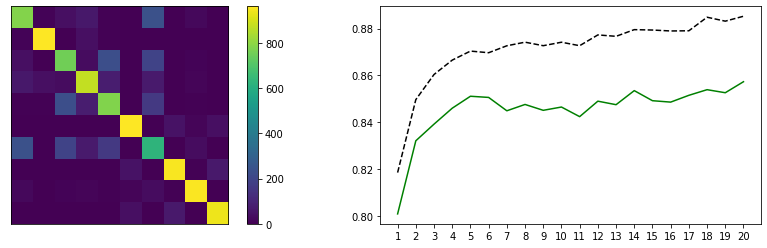

In [34]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 90),
    ReLU(),
    Linear(90, 80),
    ReLU(),
    Linear(80, 70),
    ReLU(),
    Linear(70, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.0001, steps=20)

Initial loss=6.1938, accuracy=0.0734
Final loss=0.3850, accuracy=0.8826
Test loss=0.5319, accuracy=0.8568
Elapsed time: 80.38s


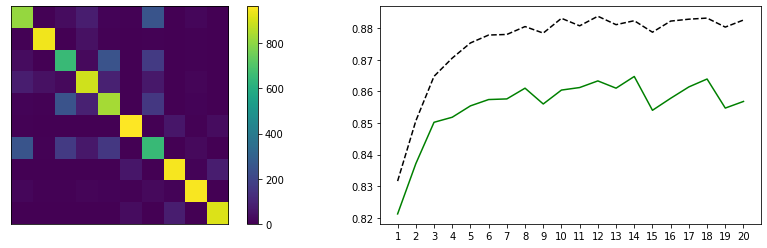

In [35]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 90),
    ReLU(),
    Linear(90, 80),
    ReLU(),
    Linear(80, 70),
    ReLU(),
    Linear(70, 60),
    ReLU(),
    Linear(60, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.0001, steps=20)

Initial loss=3.3100, accuracy=0.0564
Final loss=0.3640, accuracy=0.8859
Test loss=0.5066, accuracy=0.8617
Elapsed time: 88.83s


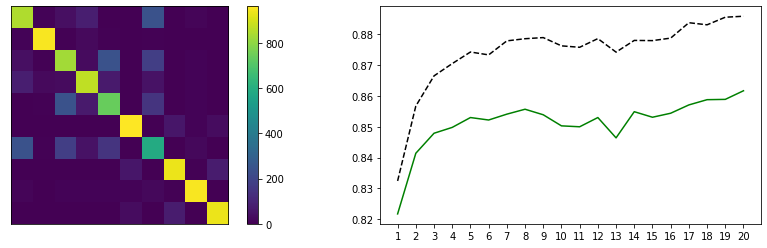

In [36]:
net = Net(loss=CrossEntropyLoss(), optimizer=Adagrad())
net.add(
    Linear(784, 90),
    ReLU(),
    Linear(90, 80),
    ReLU(),
    Linear(80, 70),
    ReLU(),
    Linear(70, 60),
    ReLU(),
    Linear(60, 50),
    ReLU(),
    Linear(50, 10),
    Softmax()
)

train_and_plot(net, fm_train_data, fm_train_labels, fm_test_data, fm_test_labels, batch_size=100, lr=0.0001, steps=20)